In [1]:
import pandas as pd
import sys
sys.path.append('..') # Pour pouvoir importer depuis src/
from src.features import frac_diff_ffd, find_min_d


In [2]:
# 1. Charger Data
df = pd.read_csv('../data/raw/train.csv').set_index('date_id').sort_index()
df = df.ffill() # permet de gérer les manquants basiquement

In [3]:
# 2. Liste des coupables (Colonnes Non-Stationnaires)
cols_to_fix = ['P10', 'P11', 'I5', 'I8', 'I9']

In [4]:
# 3. La boucle de réparation
new_features = pd.DataFrame(index=df.index)

print("--- Réparation des Features Non-Stationnaires ---")
for col in cols_to_fix:
    print(f"Traitement de {col}...")
    
    # A. Trouver le meilleur d
    best_d, p_val = find_min_d(df[col])
    
    print(f"  -> Meilleur d = {best_d} (p-value: {p_val:.4f})")
    
    # B. Appliquer la transformation
    # Attention: FFD coupe le début des données (mémoire). 
    # Ton index sera aligné, mais le début sera NaN.
    new_series = frac_diff_ffd(df[col], d=best_d)
    
    # C. Sauvegarder
    # On renomme pour garder une trace
    new_features[f"{col}_ffd"] = new_series

--- Réparation des Features Non-Stationnaires ---
Traitement de P10...
  -> Meilleur d = 0.1 (p-value: 0.0000)
Traitement de P11...
  -> Meilleur d = 0.1 (p-value: 0.0001)
Traitement de I5...
  -> Meilleur d = 0.1 (p-value: 0.0098)
Traitement de I8...
  -> Meilleur d = 0.1 (p-value: 0.0492)
Traitement de I9...
  -> Meilleur d = 0.1 (p-value: 0.0202)


In [5]:
# 4. Fusionner avec le reste
# On garde les features qui étaient déjà OK (Stationnaires)
# On remplace les mauvaises par les versions FFD
df_clean = df.drop(columns=cols_to_fix).join(new_features)

In [6]:
# --- AJOUT DE FEATURES DE SECOND ORDRE (López de Prado Chap. 17) ---
print("Création des features dérivées (Volatilité & Corrélation)...")

# 1. Volatilité Glissante (50 jours) sur les séries FFD
# Cela capture le "Régime de marché" (Calme vs Panique)
df_clean['P10_ffd_vol'] = df_clean['P10_ffd'].rolling(window=50).std()
df_clean['I5_ffd_vol'] = df_clean['I5_ffd'].rolling(window=50).std()

# 2. Corrélation Glissante (50 jours)
# Capture la dynamique entre Prix et Taux (Risk On / Risk Off)
df_clean['corr_P10_I5'] = df_clean['P10_ffd'].rolling(window=50).corr(df_clean['I5_ffd'])

# 3. Nettoyage des NaNs créés par le Rolling (les 50 premiers jours)
df_clean = df_clean.dropna()

print(f"Nouvelles dimensions avec features dérivées : {df_clean.shape}")

Création des features dérivées (Volatilité & Corrélation)...
Nouvelles dimensions avec features dérivées : (2052, 100)


In [7]:
# 5. SAUVEGARDE 
save_path = '../data/processed/train_stationary.parquet'
df_clean.to_parquet(save_path)
print(f"Fichier sauvegardé avec succès : {save_path}")

Fichier sauvegardé avec succès : ../data/processed/train_stationary.parquet


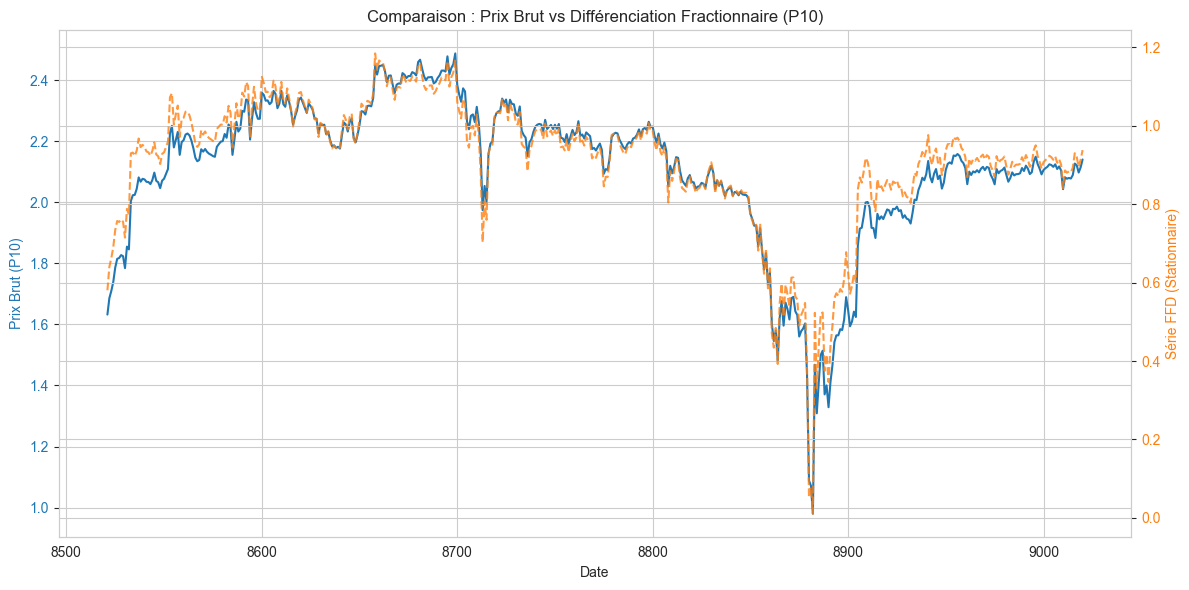

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration du style
sns.set_style("whitegrid")
fig, ax1 = plt.subplots(figsize=(12, 6))

# Série brute (P10)
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Prix Brut (P10)', color=color)
ax1.plot(df.index[-500:], df['P10'][-500:], color=color, label='Prix Brut (P10)')
ax1.tick_params(axis='y', labelcolor=color)

# Série différenciée (P10_ffd)
ax2 = ax1.twinx()  # Axe Y secondaire
color = 'tab:orange'
ax2.set_ylabel('Série FFD (Stationnaire)', color=color)
ax2.plot(df.index[-500:], df_clean['P10_ffd'][-500:], color=color, linestyle='--', alpha=0.8, label='FFD (d=0.1)')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Comparaison : Prix Brut vs Différenciation Fractionnaire (P10)')
fig.tight_layout()
plt.savefig('../reports/ffd_comparison.png', dpi=300) # Sauvegarde
plt.show()